# Ziyao Chen HW2 

## Q1

In [1]:
import numpy
from urllib.request import urlopen
import scipy.optimize
import random
from math import exp
from math import log

In [2]:
def parseData(fname):
    for l in urlopen(fname):
        yield eval(l)

print("Reading data...")
data = list(parseData("http://jmcauley.ucsd.edu/cse190/data/beer/beer_50000.json"))
print("done")

Reading data...
done


In [3]:
import random
random.shuffle(data)
train_data = data[:int(len(data)/3)]
valid_data = data[int(len(data)/3):int(len(data)/3)*2]
test_data = data[int(len(data)/3)*2:]

In [4]:
def feature(datum):
    feat = [1, datum['review/taste'], datum['review/appearance'], datum['review/aroma'], datum['review/palate'], datum['review/overall']]
    return feat

X = [feature(d) for d in train_data]
y = [d['beer/ABV'] >= 6.5 for d in train_data]

def inner(x,y):
    return sum([int(x[i])*int(y[i]) for i in range(len(x))])

def sigmoid(x):
    return 1.0 / (1 + exp(-x))

Logistic regression by gradient ascent 

In [5]:
# NEGATIVE Log-likelihood
def f(theta, X, y, lam):
    loglikelihood = 0
    for i in range(len(X)):
        logit = inner(X[i], theta)
        loglikelihood -= log(1 + exp(-logit))
        if not y[i]:
            loglikelihood -= logit
    for k in range(len(theta)):
        loglikelihood -= lam * theta[k]*theta[k]
  # for debugging
  # print("ll =" + str(loglikelihood))
    return -loglikelihood

In [6]:
# NEGATIVE Derivative of log-likelihood
def fprime(theta, X, y, lam):
    dl = [0]*len(theta)
    for i in range(len(X)):
        logit = inner(X[i], theta)
        for k in range(len(theta)):
            dl[k] += X[i][k] * (1 - sigmoid(logit))
            if not y[i]:
                dl[k] -= X[i][k]
    for k in range(len(theta)):
        dl[k] -= lam*2*theta[k]
    return numpy.array([-x for x in dl])

X_train = X
y_train = y

 Train 

In [7]:
def train(lam):
    theta,_,_ = scipy.optimize.fmin_l_bfgs_b(f, [0]*len(X[0]), fprime, pgtol = 10, args = (X_train, y_train, lam))
    return theta

## test

In [8]:
X1 = [feature(d) for d in test_data]
y1 = [d['beer/ABV'] >= 6.5 for d in test_data]
def performance(theta):
    scores = [inner(theta,x) for x in X1]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,y1)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

In [9]:
lam = 1.0
theta = train(lam)
acc = performance(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 1.0:	accuracy=0.7206023518118551


In [10]:
print("The accuracy of the classifier on the test sets is", str(acc))

The accuracy of the classifier on the test sets is 0.7206023518118551


## validation

In [11]:
X2 = [feature(d) for d in valid_data]
y2 = [d['beer/ABV'] >= 6.5 for d in valid_data]
def performancen(theta):
    scores = [inner(theta,x) for x in X2]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,y2)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

In [12]:
lam = 1.0
theta = train(lam)
acc = performancen(theta)
print("lambda = " + str(lam) + ":\taccuracy=" + str(acc))

lambda = 1.0:	accuracy=0.7173886955478219


In [13]:
print("The accuracy of the classifier on the validation sets is", str(acc))

The accuracy of the classifier on the validation sets is 0.7173886955478219


# Q2 

In [14]:
def tf(theta):
    scores = [inner(theta,x) for x in X1]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,y1)]
    positives = sum(predictions)
    negetives = len(predictions)-sum(predictions)
    TP=[(a==1 and b==1) for (a,b) in zip(predictions,y1)]
    FP=[(a==1 and b==0) for (a,b) in zip(predictions,y1)]
    TN=[(a==0 and b==0) for (a,b) in zip(predictions,y1)]
    FN=[(a==0 and b==1) for (a,b) in zip(predictions,y1)]
    truepositives=sum(TP)
    falsepositives=sum(FP)
    truenegtives=sum(TN)
    falsenegetives=sum(FN)
    return positives,negetives,truepositives,falsepositives,truenegtives,falsenegetives

In [15]:
lam = 1.0
theta = train(lam)
number=tf(theta)

In [16]:
print("The positives,negetives,true positives,false positives,true negtives and false negetives values are", number)

The positives,negetives,true positives,false positives,true negtives and false negetives values are (12359, 4309, 9087, 3272, 2924, 1385)


# Q3

## When we are calculating False Positives, our prediction is y==1, but it is labeled as y==0.  When we are calculating False Negetives, our prediction is y==0, but it is labeled as y==1.  The total cost= c1*(y*log(h_theta(x))+c2*((1-y)*log(1-h_theta(x)), the first part is the cost for False Negetives and the second part is the cost for False Positives. If I wanted to assign 10 times as much importance to False Positives as compared to False Negatives, I assign the weight as c2/c1=10.

The specific modification I would make to the code is for the log-likelihood part. I reassign weight to the loglikelihood when y==1 ande y==0 so that my c2/c1 would be 10.
If I obey the math calculation stricktly, I would revise the code as below:
First, in the part of NEGATIVE Log-likelihood "if not y[i]: loglikelihood = log(exp(logit)+1)*10".
Second, in the part of NEGATIVE Derivative of log-likelihood,"if not y[i]: dl[k] = -(X[i][k]*exp(logit))*10/(1+exp(logit))".

If I wanna do a proximation of the math calculation, I would revise the code as below:
First, in the part of NEGATIVE Log-likelihood "if not y[i]: loglikelihood -= logit*10".
Second, in the part of NEGATIVE Derivative of log-likelihood,"if not y[i]: dl[k] -= X[i][k]*10".
But since the result will show as math out of range, I would use a smaller number instead.

# Q4 

# train

In [17]:
def performancet(theta):
    scores = [inner(theta,x) for x in X]
    predictions = [s > 0 for s in scores]
    correct = [(a==b) for (a,b) in zip(predictions,y)]
    acc = sum(correct) * 1.0 / len(correct)
    return acc

In [18]:
lam=[0,0.01,0.1,1,100]
for i in range(len(lam)):
    theta = train(lam[i])
    acc = performancet(theta)
   # print("lambda = " + str(lam[i]) + ":\taccuracy=" + str(acc))

# valid

In [19]:
lam=[0,0.01,0.1,1,100]
for i in range(len(lam)):
    theta = train(lam[i])
    acc = performancen(theta)
    print("lambda = " + str(lam[i]) + ":\taccuracy=" + str(acc))

lambda = 0:	accuracy=0.718648745949838
lambda = 0.01:	accuracy=0.718708748349934
lambda = 0.1:	accuracy=0.7183487339493579
lambda = 1:	accuracy=0.7173886955478219
lambda = 100:	accuracy=0.6687867514700588


## lamda with the best accuracy is 0.01, the best accuracy associated with it is 0.718708748349934.

# test

In [23]:
theta = train(lam[1])
acc = performance(theta)
print("lambda = " + str(lam[1]) + ":\taccuracy=" + str(acc))

lambda = 0.01:	accuracy=0.720662347012239


# train

In [24]:
theta = train(lam[1])
acc = performancet(theta)
print("lambda = " + str(lam[1]) + ":\taccuracy=" + str(acc))

lambda = 0.01:	accuracy=0.7203288131525261


## Using the best lamda which is 0.01, its accuracy on the train, validation and test sets are 0.7203288131525261, 0.718708748349934 and 0.720662347012239. 

# Q5

In [10]:
#!pip3 install --user networkx

    100% |████████████████████████████████| 1.7MB 642kB/s 
  Running setup.py bdist_wheel for networkx ... done
  Stored in directory: /home/rstudio/.cache/pip/wheels/68/f8/29/b53346a112a07d30a5a84d53f19aeadaa1a474897c0423af91
Successfully built networkx


In [419]:
import networkx as nx
import matplotlib.pyplot as plt

In [420]:
import numpy
import urllib
import scipy.optimize
import random
from sklearn.decomposition import PCA
from collections import defaultdict

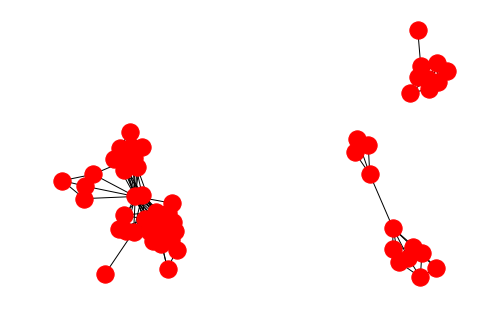

<Figure size 432x288 with 0 Axes>

In [421]:
edges = set()
nodes = set()
for edge in urllib.request.urlopen("http://jmcauley.ucsd.edu/cse255/data/facebook/egonet.txt"):
  x,y = edge.split()
  x,y = int(x),int(y)
  edges.add((x,y))
  edges.add((y,x))
  nodes.add(x)
  nodes.add(y)

G = nx.Graph()
for e in edges:
  G.add_edge(e[0],e[1])
nx.draw(G)
plt.show()
plt.clf()

# Q5 As seen in the graph, there are 3 connected components in the graph.

In [422]:
components = list(nx.connected_components(G))
components.sort(key=len, reverse=True)
largest = components.pop(0)

In [423]:
len(largest)

40

# There are 40 nodes in the largest component.

# Q6

In [434]:
largest=sorted(largest)
mylist=list(largest)
low=mylist[:20]
high=mylist[20:]

In [435]:
mylist1=list(edges)
lowedges=[]
highedges=[]
for i in mylist1:
    if i[0] in low:
        lowedges.append(i)
        
for j in mylist1:
    if j[0] in high:
        highedges.append(j)
newedges=lowedges+highedges

In [436]:
Gc = nx.Graph()
for l in newedges:
  Gc.add_edge(l[0],l[1])

In [437]:
print (nx.normalized_cut_size(Gc,high,low)/2)

0.4224058769513316


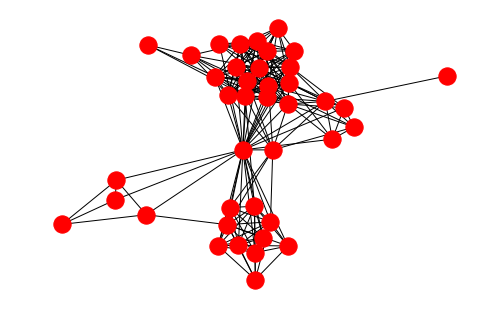

<Figure size 432x288 with 0 Axes>

In [438]:
nx.draw(Gc)
plt.show()
plt.clf()

# The normalized-cut cost of the 50/50 split I found above is 0.4224058769513316.

# Q7 What are the elements of the split, and what is its normalized cut cost?

In [439]:
len(low)

20

In [440]:
current_cost=[]
current_cost.append(nx.normalized_cut_size(Gc,low,high)/2)
current_cost[0]

0.4224058769513316

In [441]:
def normalized_cut_cost(low,high,Gc):
    com1=[]
    high1=high.copy()
    low1=low.copy()
    high0=high.copy()
    low0=low.copy()
    key=[]
    for i in range(0,len(low0)):
        l1=low0[0]
        key.append(l1)
        high0.append(l1)
        low0.remove(l1)
        com1.append(nx.normalized_cut_size(Gc,low0,high0)/2)
        low0.append(high0[-1])
        high0.remove(high0[-1])
    
    for j in range(0,len(high1)):
        l2=high1[0]
        key.append(l2)
        low1.append(l2)
        high1.remove(l2)
        com1.append(nx.normalized_cut_size(Gc,low1,high1)/2)
        high1.append(low1[-1])
        low1.remove(low1[-1])
    
    dic = dict(zip(key, com1))
    m=min(com1)
    x=com1.index(m)
    current_cost.append(m)
    if x<len(low):
        high.append(low[x])
        low.remove(low[x])
    else:
        low.append(high[x-len(low)])
        high.remove(high[x+1-len(low)])
    
    return low,high,current_cost

In [442]:
for n in range(20):
    if len(current_cost) <= 1:
        normalized_cut_cost(low,high,Gc)
    else:
        if current_cost[n] <= current_cost[n-1]:
            normalized_cut_cost(low,high,Gc)
        else:
            print(current_cost[n-1])
            print(low,high)
            break

0.09817045961624274
[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 800, 803, 805, 810, 811, 819, 828, 823, 830, 840, 880, 890, 869, 856] [825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893, 729, 804, 798]


In [443]:
len(current_cost)

12

In [444]:
low=mylist[:20]
high=mylist[20:]
for i in range(10):
    if i == 10:
        print(low,high)
    else:
        normalized_cut_cost(low,high,Gc)

In [445]:
print(low,high)

[697, 703, 708, 713, 719, 745, 747, 753, 769, 772, 774, 798, 800, 803, 805, 810, 811, 819, 828, 823, 830, 840, 880, 890, 869, 856] [825, 861, 863, 864, 876, 878, 882, 884, 886, 888, 889, 893, 729, 804]


# The elements of the split are shown as above, the first part is the low set and the second part is the high set. The best normalized cut cost is 0.09817045961624274.

# Q8 

In [24]:
#!pip3 install --user community
#!pip3 install --user python-louvain

In [339]:
largest=sorted(largest)
mylist=list(largest)
low=mylist[:20]
high=mylist[20:]

In [340]:
mylist1=list(edges)
lowedges=[]
highedges=[]
for i in mylist1:
    if i[0] in low:
        lowedges.append(i)
        
for j in mylist1:
    if j[0] in high:
        highedges.append(j)
newedges=lowedges+highedges

In [341]:
Gc = nx.Graph()
for l in newedges:
  Gc.add_edge(l[0],l[1])

In [342]:
current_mod=[]
current_mod.append(nx.algorithms.community.modularity(Gc,[low,high]))
current_mod[0]

0.07681818181818188

In [343]:
def modularity(low,high,Gc):
    com1=[]
    high1=high.copy()
    low1=low.copy()
    high0=high.copy()
    low0=low.copy()
    key=[]
    for i in range(0,len(low0)):
        l1=low0[0]
        key.append(l1)
        high0.append(l1)
        low0.remove(l1)
        com1.append(nx.algorithms.community.modularity(Gc,[low0,high0]))
        low0.append(high0[-1])
        high0.remove(high0[-1])
    
    for j in range(0,len(high1)):
        l2=high1[0]
        key.append(l2)
        low1.append(l2)
        high1.remove(l2)
        com1.append(nx.algorithms.community.modularity(Gc,[low1,high1]))
        high1.append(low1[-1])
        low1.remove(low1[-1])
    
    dic = dict(zip(key, com1))
    m=max(com1)
    x=com1.index(m)
    current_mod.append(max(com1))
    if x<len(low):
        high.append(low[x])
        low.remove(low[x])
    else:
        low.append(high[x-len(low)])
        high.remove(high[x+1-len(low)])
    
    return low,high,current_mod

In [344]:
for i in range(0,20):
    if  current_mod[i]>= current_mod[i-1]:
        modularity(low,high,Gc)
    else :
        print(current_mod[i-1])
        break

0.33801652892561973


# The modularity values for the 50/50 split I have found is 0.33801652892561973.